In [1]:
from ema_workbench import load_results

In [2]:
results = load_results('./results/test 100.tar.gz')

In [3]:
experiments, outcomes = results

In [5]:
filtered_outcomes = {key:value for key, value in outcomes.items() if not key.startswith("Damage_")}

In [6]:
filtered_outcomes.keys()

dict_keys(['Steel_UnsatisfiedDemand', 'Garment_TravelTime', 'Brick_UnsatisfiedDemand', 'Textile_TransportCost', 'Brick_TravelTime', 'Food_TransportCost', 'Food_UnsatisfiedDemand', 'Steel_TransportCost', 'Brick_TransportCost', 'Garment_TransportCost', 'Food_TravelTime', 'Steel_TravelTime', 'Textile_TravelTime', 'Textile_UnsatisfiedDemand', 'Garment_UnsatisfiedDemand'])

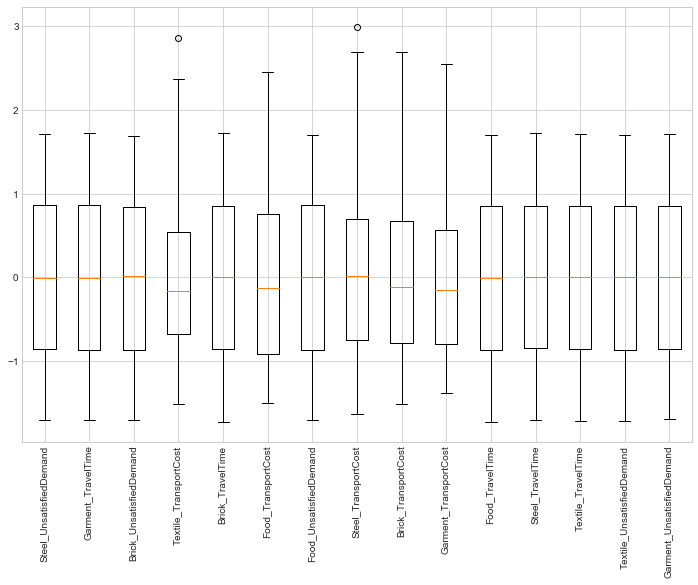

In [24]:
fig, ax = plt.subplots()

labels, data = zip(*list(filtered_outcomes.items()))
data = [(entry-np.mean(entry))/np.std(entry) for entry in data]
ax.boxplot(data, labels=labels)
plt.xticks(rotation=90)
plt.show()

In [25]:
import itertools
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import pandas as pd
from sklearn import preprocessing

# Created on 11 Sep 2017
#
# .. codeauthor::jhkwakkel <j.h.kwakkel (at) tudelft (dot) nl>

__all__ = []

def setup_parallel_plot(labels, minima, maxima, fs=14):
    sns.set_style('white')
    #labels is a list, minima and maxima pd series
    nr_columns = len(labels)
    fig = plt.figure()
    axes = [] 
    tick_labels = {}
    
    # we need one axes less than the shape
    for i, label in enumerate(labels[:-1]):
        i += 1
        ax = fig.add_subplot(1,nr_columns-1,i,  ylim=(-0.1,1.1))
        axes.append(ax)
        ax.set_xlim([i,i+1])
        ax.xaxis.set_major_locator(ticker.FixedLocator([i]))
        ax.xaxis.set_ticklabels([labels[i-1]], rotation=90, fontsize=fs)
        ax.xaxis.set_tick_params(bottom=False, top=False)
        
        #let's put our own tick labels
        ax.yaxis.set_ticks([])
        max_label = "{:.2f}".format(maxima[label])
        min_label = "{:.2f}".format(minima[label])
        max_label= ax.text(i, 1.01, max_label, va="bottom",
                           ha="center", fontsize=fs)
        min_label= ax.text(i, -0.01, min_label, va="top",
                           ha="center", fontsize=fs)
        tick_labels[label] = (min_label, max_label)
        
        ax.spines['left'].set_bounds(0, 1)
        ax.spines['right'].set_bounds(0, 1)
        ax.spines['top'].set_visible(False)
        ax.spines['bottom'].set_visible(False)

    
    # for the last axis, we need 2 ticks (also for the right hand side
    ax.xaxis.set_major_locator(ticker.FixedLocator([i, i+1]))
    ax.xaxis.set_ticklabels(labels[i-1:i+1], fontsize=fs)

    label = labels[-1]
    max_label = "{:.2f}".format(maxima[label])
    min_label = "{:.2f}".format(minima[label])
    max_label = ax.text(i+1, 1.01, max_label, va="bottom",
                        ha="center", fontsize=fs)
    min_label = ax.text(i+1, -0.01, min_label, va="top",
                        ha="center", fontsize=fs)
    tick_labels[label] = (min_label, max_label)

    
    # add the tick labels to the rightmost spine
    for tick in ax.yaxis.get_major_ticks():
        tick.label2On=True
    
    # stack the subplots together
    plt.subplots_adjust(wspace=0)
    
    return fig, axes, tick_labels


class ParcoordsFigure(object):
    
    def __init__(self, data, groupby=None, drop=True, color=None):
        '''
        
        Parameters
        ----------
        data :  pd.Dataframe
        groupby : str, optional
        drop : bool, optional
               if true, remove groupby column from data to be visualized
        color : valid mpl color, or list of colors
        
        TODO:: optional color argument (uniform color for all, list for each group)
        
        '''
        
        super(ParcoordsFigure, self).__init__()
        self.data = data
        self.fs = 14
        
        # recode data
        
        # normalize data 
        min_max_scaler = preprocessing.MinMaxScaler()
        self.norm_data = pd.DataFrame(min_max_scaler.fit_transform(self.data),
                                     columns=self.data.columns)
        
        labels = list(data.columns.values)
        if groupby and drop:
            labels.remove(groupby)
        
        fig, axes, tick_labels = setup_parallel_plot(labels, data.min(), 
                                                     data.max(), fs=self.fs)
            
        self.fig = fig
        self.axes = axes
        self.ticklabels = tick_labels
        self.lines = pd.DataFrame(np.zeros((data.values.shape[0], 
                                            len(self.axes)), dtype=np.object),
                            columns=[x for x in range(len(self.axes))])
        
        if color is None:
            colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
        else:
            # check natur of colors (list or 1 color this is tricky...)
            colors = color
        
        if groupby:
            colors = itertools.cycle(colors)
            some_identifiers = []
            for groupname, group in self.norm_data.groupby(groupby):
                c = next(colors)
                self._plot(axes, labels, group, c=c)
                some_identifiers.append((groupname, 
                                         plt.Line2D([0,1], [0,1], c=c)))
                
            labels, some_identifiers = zip(*some_identifiers)
            axes[-1].legend(some_identifiers, labels, loc=2,
                            borderaxespad=0.1, fontsize=self.fs,
                            bbox_to_anchor=(1.3, 0.95))
        else:
            self._plot(axes, labels, self.norm_data, c=color)

    def _plot(self, axes, labels, data, c=None):
        j=-1
        for ax, label_i, label_j in zip(axes, labels[:-1], labels[1::]):
            plotdata = data.loc[:,[label_i, label_j]]
            j += 1
            x = np.tile([j+1,j+2], (plotdata.shape[0], 1))
            for index, row in plotdata.iterrows():
                line = ax.plot([j+1, j+2], row.values, c=c)
                self.lines.loc[index, j] = line
            
    def set_lims(self, axis, minimum, maximum):
        # axis is string or list of strings
        # min and max, scalar or iterable of scalars
        pass
    
    
    def brush(self, axis, brush):
        if isinstance(axis, str):
            axis = [axis]
            brush = [brush]
        assert len(axis)==len(brush)
        logical = np.ones(self.data.shape[0], dtype=np.bool)
        print(logical.shape)
        for a, brushlim in zip(axis, brush):
            datum = self.data.loc[:,a]
            logical = logical & (datum >= brushlim[0]) & (datum <= brushlim[1])
        inverse = logical==False
        
        for i in range(len(self.axes)):
                lines = self.lines.loc[inverse, i]
                for line in lines:
                    line[0].set_color('lightgrey')
                    line[0].set_zorder(1)

    
    def set_ticks(self, axis, ticks):
        pass
    
    
    def set_ticklabels(self, axis, ticks):
        pass
    
    
    def invert_axis(self, axis):
        '''flip direction for specified axis
        
        Parameters
        ----------
        axis : str or list of str
        
        '''
        
        if isinstance(axis, str):
            self._invert_axis(axis)
        else:
            for entry in axis:
                self._invert_axis(entry)
           
    def _invert_axis(self, axis):
        ids = self._get_axes_ids(axis)
        
        if len(ids) == 1:
            id = ids[0]
            if id == 0:
                index = 0
            else:
                index = 1

            ax = self.axes[id]
            self._update_plot_data(axis, ax, index)
        else:
            left, right = ids
            self._update_plot_data(axis, self.axes[left], 1)
            self._update_plot_data(axis, self.axes[right], 0)
            
        
    def _update_plot_data(self, axis, ax, index):
        lines = ax.get_lines()
        for line in lines:
            ydata = line.get_data()[1]
            ydata[index] = 1- ydata[index]
            line.set_ydata(ydata)
            
        if index==0:
            labels = self.ticklabels[axis]

            for label in labels:
                x, y = label.get_position()
                if y == -0.01:
                    y = 1.01
                    label.set_va('bottom')
                else:
                    y = -0.01
                    label.set_va('top')
                label.set_position((x,y))
                
                
    def _get_axes_ids(self, column):
        index = self.data.columns.get_loc(column) 
        if index == 0 or index >= (len(self.axes)): 
            index = min(index, (len(self.axes)-1)) 
            return (index,)
        else:
            other_index = index-1
            return other_index, index
    

/Users/jhkwakkel/anaconda/lib/python3.6/importlib/_bootstrap.py:205: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
/Users/jhkwakkel/anaconda/lib/python3.6/importlib/_bootstrap.py:205: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)


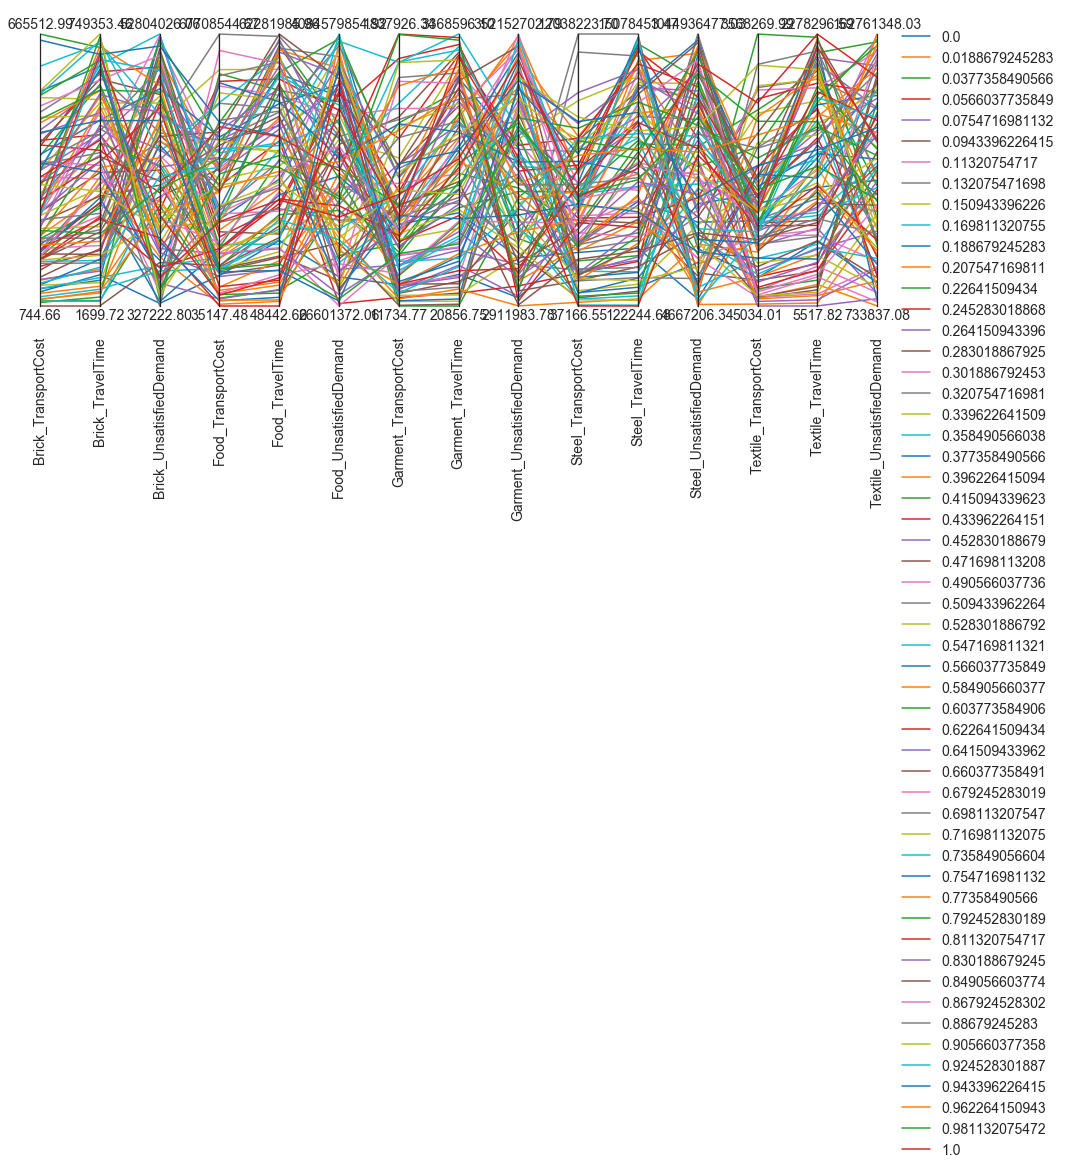

In [36]:
data = pd.DataFrame.from_dict(filtered_outcomes)
data['flooding scenario'] = pd.Series(experiments['Flood_area'])

for column, dtype in data.dtypes.iteritems():
    if dtype=='object':
        column_data = pd.Categorical(data[column] )
        recoded = column_data.codes
        data[column] = recoded

fig = ParcoordsFigure(data, groupby='flooding scenario')
fig.fig.set_size_inches(15, 6)
plt.show()